# Expected Goals Model

Slim model using limited number of features.

In [1]:
import os
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

### Downloading Data
__Only do this if you do not have data on local drive. This will download ~3GB of data.__

First, let us load the data from an [AWS S3 bucket](https://s3.console.aws.amazon.com/s3/buckets/nhl-api-game-events?region=us-west-2&tab=objects#). Data was originally retrieved from the [NHL Public API](https://gitlab.com/dword4/nhlapi/-/blob/master/stats-api.md).

In [2]:
# import boto3

# # input your credentials, bucket is public but we need a personal AWS account these to gain programatic access
# s3 = boto3.client(
#     's3',
#     aws_access_key_id='xxxx',
#     aws_secret_access_key='xxxxx'
# )

# # download objects to data foler
# BUCKET_NAME = 'nhl-api-game-events'
# seasons = ['2015', '2016', '2017', '2018', '2019', '2020', '2021']
# for season in seasons:
#     OBJECT_NAME = f'{season}_regSeasonPlays.json'
#     FILE_NAME = f'../data/gameData/{season}_regSeasonPlays.json'
#     s3.download_file(BUCKET_NAME, OBJECT_NAME, FILE_NAME)

### Loading Data

Load data into memory, adjust _path_ variable to point to data files.

In [3]:
years = ['2015','2016','2017','2018', '2019', '2020', '2021']
games = {}
for year in years:
    path = '../../../DATA/regularSeason/' + year + '_regSeasonPlays.json'
    print(path)
    with open(path) as f:
        games[year] = json.load(f)

../../../DATA/regularSeason/2015_regSeasonPlays.json
../../../DATA/regularSeason/2016_regSeasonPlays.json
../../../DATA/regularSeason/2017_regSeasonPlays.json
../../../DATA/regularSeason/2018_regSeasonPlays.json
../../../DATA/regularSeason/2019_regSeasonPlays.json
../../../DATA/regularSeason/2020_regSeasonPlays.json
../../../DATA/regularSeason/2021_regSeasonPlays.json


### Data Mining

Extract shots from the raw data.

In [4]:
# get information we care about: shots and goals
shots = []
for season in games:
    for game_id in games[season]:
        home_team = games[season][game_id]['home_team']
        away_team = games[season][game_id]['away_team']
        for event in games[season][game_id]['events']:
            # if event is shot or goal, save it
            if event['result']['event'] == 'Shot' or event['result']['event'] == 'Goal':
                shooter = ''
                shooter_id = 0
                goalie = ''
                goalie_id = 0

                # extract shooter/goalie
                for player in event['players']:
                    if player['playerType'] == 'Shooter' or player['playerType'] == 'Scorer':
                        shooter = player['player']['fullName']
                        shooter_id = player['player']['id']
                    elif player['playerType'] == 'Goalie':
                        goalie = player['player']['fullName']
                        goalie_id = player['player']['id']

                # extract shooter/goalie team
                shooter_team = event['team']['name']
                goalie_team = home_team
                if goalie_team == shooter_team: goalie_team = away_team

                # extract strength for goal
                strength = 'unknown'
                try:
                    strength = event['result']['strength']['name']
                except:
                    pass

                shots.append({
                    'season_id': season,
                    'game_id': game_id,
                    'home_team': home_team,
                    'away_team': away_team,
                    'dateTime': event['about']['dateTime'],
                    'period': event['about']['period'],
                    'periodTime': event['about']['periodTime'],
                    'x_loc': event['coordinates'].get('x', np.NaN),
                    'y_loc': event['coordinates'].get('y', np.NaN),
                    'shooter': shooter,
                    'shooter_id': shooter_id,
                    'shooter_team': shooter_team,
                    'goalie': goalie,
                    'goalie_id': goalie_id,
                    'goalie_team': goalie_team,
                    'is_goal': (event['result']['event'] == 'Goal'),
                    'shot_type': event['result'].get('secondaryType'),                
                    'strength': strength
                })

### Feature engineering
The following features are extracted from the raw data and used as predictors in our models. Additional data, such as shooter/goalie characteristics and travel between timezones are extracted.

* time since last shot (time in period) **records of actual time are inaccurate
* coordinates location of shoot
* change of angle since last shot
* change in distance since last shot

In [5]:
# convert to dataframe
df = pd.DataFrame(shots)
df = df[df['goalie'] != ''] # filter empty net goals
df = df[df['period'] != 5] # filter shootout attempts


# find total seconds between shots (periodTime)
df['time_seconds'] = df['periodTime'].str[:2].astype(int) * 60 + df['periodTime'].str[3:].astype(int)
df['time_seconds'] = np.where(df['period'] == 2, df['time_seconds'] + 1200, 
                                 np.where(df['period'] == 3, df['time_seconds'] + 2400, df['time_seconds']))
df = df.sort_values(by=['game_id', 'goalie', 'time_seconds']) # sort by game_id and goalie name
df['time_seconds_diff'] = df.groupby(['game_id', 'goalie'])['time_seconds'].diff(1).fillna(df['time_seconds'])

# get total shots
df['tot_shots'] = 1
df['tot_shots'] = df.groupby(['game_id', 'goalie'])['tot_shots'].cumsum()

# fix all shots to one side of ice (adjust x and y coordinates)
df.loc[df['x_loc'] < 0, 'y_loc'] = df['y_loc'] * -1
df['x_loc'] = df['x_loc'].abs()
df = df[df['x_loc'].notna()]

# calculate angle of shot compared to goal
x_goal = 89
df['shot_angle'] = np.where(df['x_loc'] != x_goal,
                            # when shot is from behind the net
                            np.where(df['x_loc'] > x_goal,
                                     np.where(df['y_loc'] >= 0,
                                              round(90 + (90 - np.arctan(df['y_loc'] / (df['x_loc'] - x_goal)) * (180 / np.pi)), 2),
                                              round(-90 - (90 + np.arctan(df['y_loc'] / (df['x_loc'] - x_goal)) * (180 / np.pi)), 2)
                                             ),
                                     # when shot is in front of net
                                     round(np.arctan(df['y_loc'] / (x_goal - df['x_loc'])) * (180 / np.pi), 2)
                                    ),
                            # when shot is taken on the goal line
                            np.where(df['y_loc'] >= 0, 90, -90)
                           )

# calculate difference in shot angle
df['shot_angle_prev'] = df.groupby(['game_id', 'goalie'])['shot_angle'].shift(1).fillna(0)
df['shot_angle_diff'] = np.absolute(np.where(df['shot_angle'] < df['shot_angle_prev'],
                                                df['shot_angle'] - df['shot_angle_prev'],
                                                df['shot_angle_prev'] - df['shot_angle']
                                            )
                                   )

# determine if goalie moved to his right since last shot to attempt to make save
df['goalie_move_right'] = np.where(df['shot_angle'] > df['shot_angle_prev'], True, False)

# calculate shot distance to goal
df['shot_dist'] = round(np.sqrt(np.square(df['x_loc'] - x_goal) + np.square(df['y_loc'])), 2)
df['shot_dist_prev'] = df.groupby(['game_id', 'goalie'])['shot_dist'].shift(1).fillna(0)
df['shot_dist_diff'] = df['shot_dist'] - df['shot_dist_prev']

# generate dummy vars for shot_type
df = pd.get_dummies(df, columns=['shot_type'])


# drop rows with missing values
df.dropna(axis=0, inplace=True) 

df.head()

,season_id,game_id,home_team,away_team,dateTime,period,periodTime,x_loc,y_loc,shooter,...,shot_dist,shot_dist_prev,shot_dist_diff,shot_type_Backhand,shot_type_Deflected,shot_type_Slap Shot,shot_type_Snap Shot,shot_type_Tip-In,shot_type_Wrap-around,shot_type_Wrist Shot
0,2015,2015020001,Toronto Maple Leafs,Montréal Canadiens,2015-10-07T23:24:23Z,1,00:51,55.0,-6.0,Brad Boyes,...,34.53,0.00,34.53,0,0,0,0,0,0,1
1,2015,2015020001,Toronto Maple Leafs,Montréal Canadiens,2015-10-07T23:24:38Z,1,01:05,79.0,-0.0,Nazem Kadri,...,10.00,34.53,-24.53,0,0,0,1,0,0,0
2,2015,2015020001,Toronto Maple Leafs,Montréal Canadiens,2015-10-07T23:27:21Z,1,01:06,75.0,1.0,Nazem Kadri,...,14.04,10.00,4.04,0,0,0,1,0,0,0
3,2015,2015020001,Toronto Maple Leafs,Montréal Canadiens,2015-10-07T23:25:24Z,1,01:53,55.0,36.0,Daniel Winnik,...,49.52,14.04,35.48,0,0,0,0,0,0,1
4,2015,2015020001,Toronto Maple Leafs,Montréal Canadiens,2015-10-07T23:27:08Z,1,02:37,61.0,1.0,Joffrey Lupul,...,28.02,49.52,-21.50,0,0,0,0,1,0,0


### EDA

Confirm features make sense.

##### Shot Timeline and Shot Outcome

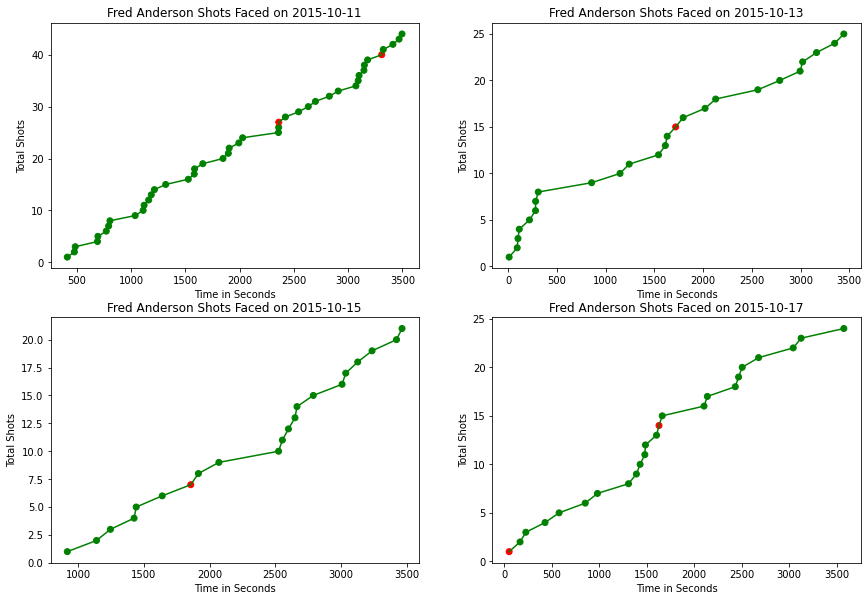

In [6]:
df_tmp = df[df['goalie']=='Frederik Andersen'].sort_values(['game_id', 'time_seconds'])
game_ids = df_tmp['game_id'].unique().tolist()[0:4] # get list of four games

# initiate plots
fig = plt.figure()
subs = [221,222,223,224]

for i in range(0,len(game_ids)):
    df_tmp2 = df_tmp[df_tmp['game_id']==game_ids[i]]
    date = df_tmp2['dateTime'].iloc[0][0:10]
    color = ['red' if goal else 'green' for goal in df_tmp2['is_goal'] ]

    ax=fig.add_subplot(subs[i])
    ax.scatter(df_tmp2['time_seconds'], df_tmp2['tot_shots'], c=color)
    ax.plot(df_tmp2['time_seconds'], df_tmp2['tot_shots'], color='green')
    plt.title(f'Fred Anderson Shots Faced on {date}')
    plt.xlabel("Time in Seconds")
    plt.ylabel("Total Shots")

plt.subplots_adjust(top=2, right=2)
plt.show()

##### Shot Location and Outcome

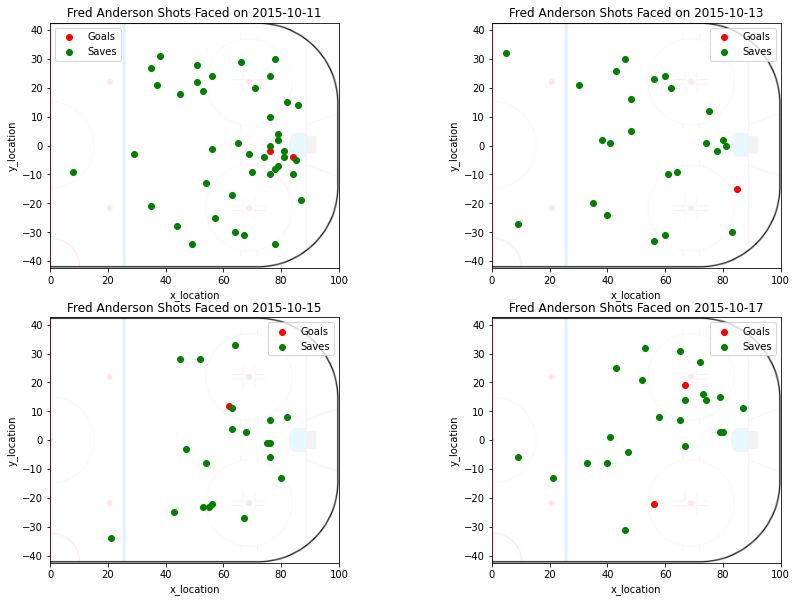

In [7]:
df_tmp = df[df['goalie']=='Frederik Andersen'].sort_values(['game_id', 'time_seconds'])
game_ids = df_tmp['game_id'].unique().tolist()[0:4] # get list of four games

# initiate plots
fig = plt.figure()
subs = [221,222,223,224]

for i in range(0,len(game_ids)):
    df_tmp2 = df_tmp[df_tmp['game_id']==game_ids[i]]
    date = df_tmp2['dateTime'].iloc[0][0:10]

    # read img (retrieved from https://thewincolumn.ca/2021/01/15/r-tutorial-creating-an-nhl-rink-using-the-tidyverse/)
    img = plt.imread("../data/images/nhl_rink_plot_output_light.png")
    ax = fig.add_subplot(subs[i])
    ax.imshow(img, extent=[0, 100, -42.5, 42.5])

    # plot
    goals = ax.scatter(df_tmp2[df_tmp2['is_goal']==True]['x_loc'], 
                        df_tmp2[df_tmp2['is_goal']==True]['y_loc'], 
                        c='red', 
                        label='Goals')
    non_goals = ax.scatter(df_tmp2[df_tmp2['is_goal']==False]['x_loc'], 
                            df_tmp2[df_tmp2['is_goal']==False]['y_loc'], 
                            c='green', 
                            label='Saves')
    plt.title(f'Fred Anderson Shots Faced on {date}')
    plt.xlabel("x_location")
    plt.ylabel("y_location")
    ax.legend()

plt.subplots_adjust(top=2, right=2)
plt.show()

##### Change in Angle and Shot Outcome

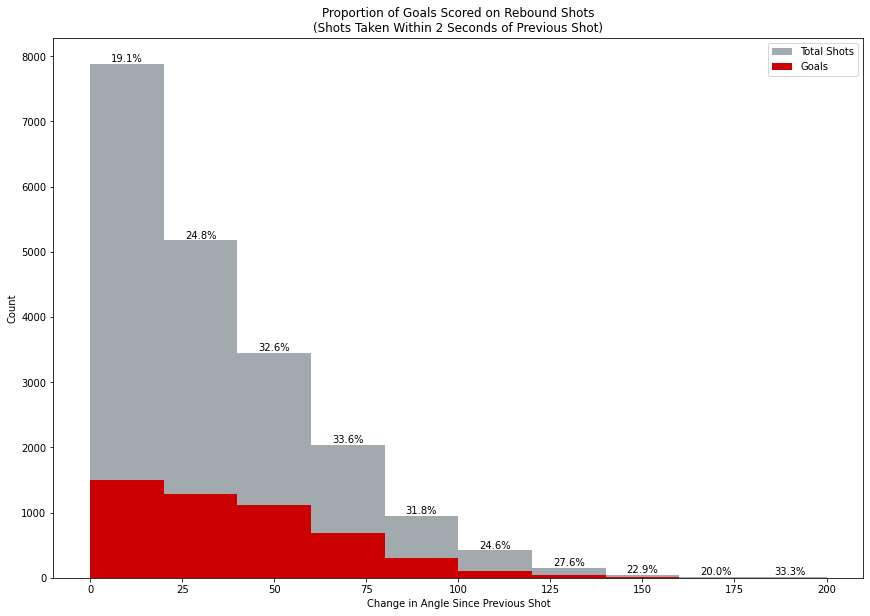

In [8]:
df_rebounds = df[df['time_seconds_diff'] <= 2].copy() # get shots with previous shot taken in past 3 seconds
# df_rebounds = df_rebounds[df_rebounds['goalie'] != ''] # filter empty netters

fig, ax = plt.subplots()

bins = list(np.linspace(0,200,11))
non_goals = plt.hist(df_rebounds['shot_angle_diff'],
                        color='#A2AAAD',
                        label='Total Shots',
                        bins=bins)
goals = plt.hist(df_rebounds[df_rebounds['is_goal'] == True]['shot_angle_diff'],
                color='#CC0000',
                label='Goals',
                bins=bins)

plt.title('Proportion of Goals Scored on Rebound Shots\n(Shots Taken Within 2 Seconds of Previous Shot)')
plt.xlabel("Change in Angle Since Previous Shot")
plt.ylabel("Count")
ax.legend()

# create labels
rects = ax.patches
labels = []
for i in range(len(goals[0])):
    labels.append(round(goals[0][i] / non_goals[0][i] * 100,1))


# apply labels
for rect, label in zip(rects, labels):
    height = rect.get_height()
    text_color = 'black'
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)
    
plt.subplots_adjust(top=2, right=2)
plt.show()

##### Shot Type and Shot Outcome

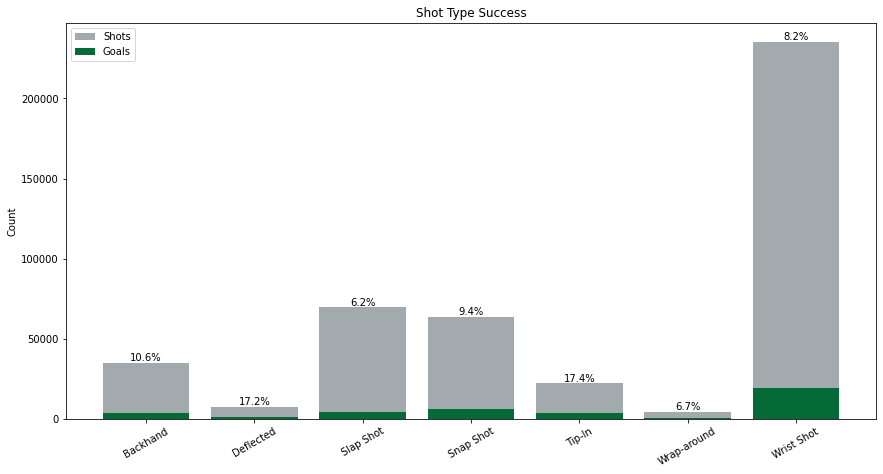

In [9]:
# get goal counts for each type of shot
df_tmp = df[['is_goal', 'shot_type_Backhand', 'shot_type_Deflected', 'shot_type_Slap Shot',
            'shot_type_Snap Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around', 'shot_type_Wrist Shot']].copy() 

# extract data as arrays
x_labels = ['Backhand', 'Deflected', 'Slap Shot', 'Snap Shot', 'Tip-In', 'Wrap-around', 'Wrist Shot']
goals = df_tmp[df_tmp['is_goal']].sum()[1:].values
all_shots = df_tmp.sum()[1:].values

fig = plt.figure()

#### create skater performance plot ###
ax1 = fig.add_subplot()
skater_shots = ax1.bar(x_labels, all_shots,
                color='#A2AAAD',
                label='Shots')
skater_goals = ax1.bar(x_labels, goals,
                color='#046A38',
                label='Goals')
ax1.legend()
plt.title('Shot Type Success')
plt.xlabel("")
plt.ylabel("Count")
plt.xticks(rotation=30)

# print goal percentage for each timezone
rects = ax1.patches # create labels
labels = []
for i in range(len(goals)):
    labels.append(round(goals[i] / all_shots[i] * 100,1))
for rect, label in zip(rects, labels): # apply labels
    height = rect.get_height()
    text_color = 'black'
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)

plt.subplots_adjust(top=1.5, right=2)
plt.show()

### Model Building

In [10]:
# model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# linear models
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV, Lasso, LassoCV
            
# tree based models            
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# other stuff
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer

##### Test Train Split

We wish to take a stratified test-train-split of 70% training and 30% testing. Here, strata will be the season each shot came from -- we wish to compose our test/train datasets with similar proportions of shots from each season.

In [11]:
#### delete columns that are unnecessary ####
cols_to_drop = ['game_id', 'home_team', 'away_team',
                'dateTime', 'period', 'periodTime',
                'shooter_team', 'goalie_team', 'strength', 
                'shot_angle_prev', 'shot_dist_prev']
df = df.drop(cols_to_drop, axis=1)

In [12]:
#### book-keeping dataset ####
# in order for our custom scoring metric to work, we need to have a way to re-map
## shot probabilities and shot outcomes back to the original shooters/goalies
df_results = df[['shooter', 'shooter_id', 'goalie', 'goalie_id', 'is_goal']] # use this to score model performance


#### original data ####
# copy dataframe, then drop unecessary cols
df_tmp = df.copy()
df_tmp.drop(['shooter', 'shooter_id', 'goalie', 'goalie_id'], axis=1, inplace=True)

# begin splitting dataset
df_2021FinalModelComparison = df_tmp[df_tmp['season_id'] == '2021'].drop('season_id', axis=1) # final holdout set
df_tmp = df_tmp[df_tmp['season_id'] != '2021']
y = df_tmp.pop('is_goal') # response vector
X = df_tmp.copy()         # predictors
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=123, 
                                                    stratify=X['season_id'])
X_train.drop('season_id', axis=1, inplace=True) # get rid of season_id ... after splitting, we have no use for this
X_test.drop('season_id', axis=1, inplace=True)


#### normalized data - neccessary for logit models ####
# re-copy dataframe and drop unnecessary columns
df_tmp = df.copy()
df_tmp.drop(['shooter', 'shooter_id', 'goalie', 'goalie_id'], axis=1, inplace=True)

# scale all numeric columns
scaler = MinMaxScaler()  # initialize scaler
df_tmp[list(df_tmp.columns)[1:]] = scaler.fit_transform(df_tmp[list(df_tmp.columns)[1:]]) # scale all columns

# begin splitting scaled dataset
df_2021FinalModelComparison_scaled = df_tmp[df_tmp['season_id'] == '2021'].drop('season_id', axis=1) # final holdout set
df_tmp = df_tmp[df_tmp['season_id'] != '2021']
y = df_tmp.pop('is_goal') # response vector
X = df_tmp.copy()         # predictors
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X, 
                                                                                y, 
                                                                                test_size=0.3, 
                                                                                random_state=123,
                                                                                stratify=X['season_id'])
X_train_scaled.drop('season_id', axis=1, inplace=True) # get rid of season_id ... after splitting, we have no use for this
X_test_scaled.drop('season_id', axis=1, inplace=True)

##### Model Training

We will train the following models:

* Linear Models
* Linear Regression
* Logistic Regression
* Ridge Regression
* Lasso Regression
* Tree-Based Models
* Decision Tree
* Bagged Tree
* Random Forest Tree
* Boosted Tree

##### Hyperparameter Tuning

For hyperparameter tuning, we will opt for a custom scoring metric. The scoring function is calculated using the following steps:

* Predict shot probabilities
* Re-map shot probabilities/outcomes back to original shooter_id
* Calculate the sum of shot probabilities for each shooter_id (expected goals)
* Calculate the sum of shot outcomes for each shooter_id (actual goals)
* Calculate the difference between the above two metrics (residual)
* Use these residuals to calculate the RMSE (root-mean-squared error) of this model

Hyperparameters are tuned using 5-fold cross-validation (where appropriate).

In [13]:
def get_rmse(probabilities, shotta, y_test):
    
    # get list of shots tested, add column of shot probability predictions
    df_test = pd.DataFrame(y_test)
    df_test['is_goal_probability'] = probabilities
    df_test.sort_index(inplace=True)

    # join with original dataframe containing skater/goalie names, and shot results
    df_test = df_results[df_results.index.isin(df_test.index)].join(df_test[['is_goal_probability']])

    # get expected goals for each skater
    groups = ['goalie_id', 'goalie']
    if shotta:
        groups = ['shooter_id', 'shooter']
    test_results = df_test.groupby(groups)[['is_goal', 'is_goal_probability']].sum().sort_values('is_goal', ascending=False)
    test_results['error'] = test_results['is_goal_probability'] - test_results['is_goal']
    rmse = np.sqrt(np.mean(np.square(test_results['error'])))
    return rmse

# custom scoring function
def my_custom_loss_func(y_test, y_pred):
    return get_rmse(y_pred, False, y_test)
custom_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

In [14]:
#### linear regression ####

# initiate model
linreg = LinearRegression()

# fit model
linreg.fit(X_train, y_train)

LinearRegression()

In [15]:
#### logistic regression ####

# initiate model
logit = LogisticRegression(max_iter=200)

# fit model
logit.fit(X_train_scaled, y_train_scaled)

LogisticRegression(max_iter=200)

In [16]:
#### ridge regression ####

# initiate the cross validation over alphas
r_alphas = np.logspace(0, 5, 50)
ridgereg = RidgeCV(cv=5, 
                   alphas=r_alphas, 
                   scoring=custom_scorer)

# fit the model with the best alpha
ridgereg = ridgereg.fit(X_train_scaled, y_train_scaled)

In [17]:
#### lasso regression ####

# initiate the cross validation over alphas
alphas = np.array([5, 0.5, 0.05, 0.005, 0.0005, 1, 0.1, 0.01, 0.001, 0.0001])
grid = GridSearchCV(estimator=Lasso(), 
                    cv=5,
                    param_grid=dict(alpha=alphas), 
                    scoring=custom_scorer)

# fit the model with the best alpha
lassoreg = grid.fit(X_train_scaled, y_train_scaled)

In [18]:
#### decision tree ####

# use 5-fold cv to get optimal set of hyperparams
param_grid = {"criterion": ['squared_error'],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 4, 8, 16, 32],
              "min_samples_leaf": [20],
              "max_leaf_nodes": [5, 20, 100],
              }
grid_dtm = GridSearchCV(DecisionTreeRegressor(random_state = 123), 
                        cv=5,
                        param_grid=param_grid, 
                        scoring=custom_scorer)

# fit the model
grid_dtm = grid_dtm.fit(X_train, y_train)
dtm = grid_dtm.best_estimator_

In [19]:
#### bagged tree ####

# use 5-fold cv to get optimal set of hyperparams
param_grid = {"n_estimators": [10, 50, 100],
              "max_features": [2, 5, 10]
              }
grid_bagtm = GridSearchCV(estimator=BaggingRegressor(n_jobs=-1, random_state=123), 
                          cv=5,
                          param_grid=param_grid, 
                          scoring=custom_scorer)

# fit the model
grid_bagtm = grid_bagtm.fit(X_train, y_train)
bagtm = grid_bagtm.best_estimator_

In [20]:
#### random forest tree ####

# use 5-fold cv to get optimal set of hyperparams
param_grid = {"n_estimators": [10, 50, 100],
              "max_depth": [1, 2, 3]
              }
grid_rftm = GridSearchCV(estimator=RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=123), 
                          cv=5,
                          param_grid=param_grid, 
                          scoring=custom_scorer)

# fit the model
grid_rftm = grid_rftm.fit(X_train, y_train)
rftm = grid_rftm.best_estimator_

In [21]:
#### boosted tree ####

# use 5-fold cv to get optimal set of hyperparams
param_grid = {"n_estimators": [10, 50, 100],
              "max_depth": [1, 2, 3],
              "alpha": [0.01, 0.1]
              }
grid_boosttm = GridSearchCV(estimator=GradientBoostingRegressor(max_features='sqrt', random_state=123), 
                          cv=5,
                          param_grid=param_grid, 
                          scoring=custom_scorer)

# fit the model
grid_boosttm = grid_boosttm.fit(X_train, y_train)
boosttm = grid_boosttm.best_estimator_

##### Model Testing

Here, we compare computed error rates of each model. Models have two scores: skater RMSE and goalie RMSE (explanation of calculation in 'Model Training' section). For final model selection, the model with the lowest skater RMSE will be selected.

In [22]:
def get_shooter_rmse(probabilities, y_test):
    return get_rmse(probabilities, True, y_test)

def get_goalie_rmse(probabilities, y_test):
    return get_rmse(probabilities, False, y_test)

def print_rmse(probabilities, y_test):
    print(f'Skaters RMSE: {get_shooter_rmse(probabilities, y_test)}')
    print(f'Goalies RMSE: {get_goalie_rmse(probabilities, y_test)}\n')

In [23]:
#### Linear Regression Testing ####
pred = linreg.predict(X_test)
print('Linear Regression:')
print_rmse(pred, y_test)

#### Logistic Regression Testing ####
probs = logit.predict_proba(X_test_scaled)
pred = pd.DataFrame(probs)[1].values
print('Logistic Regression:')
print_rmse(pred, y_test_scaled)

#### Ridge Regression Testing ####
pred = ridgereg.predict(X_test_scaled)
print(f'Ridge Regression with alpha={round(ridgereg.alpha_, 2)}:')
print_rmse(pred, y_test_scaled)

#### Lasso Regression Testing ####
pred = lassoreg.predict(X_test_scaled)
print(f'Lasso Regression with alpha={lassoreg.best_estimator_.alpha}:')
print_rmse(pred, y_test_scaled)

Linear Regression:
Skaters RMSE: 3.226704537081373
Goalies RMSE: 9.45234989841613

Logistic Regression:
Skaters RMSE: 3.366085813650254
Goalies RMSE: 9.224229904590375

Ridge Regression with alpha=12067.93:
Skaters RMSE: 3.6837313970052197
Goalies RMSE: 8.816340771726775

Lasso Regression with alpha=0.005:
Skaters RMSE: 3.792846321498757
Goalies RMSE: 8.907684817811873



In [24]:
#### Decision Tree Regressor Testing ####
pred = dtm.predict(X_test)
print(f'Decision Tree Regressor')
print_rmse(pred, y_test)

#### Bagged Tree Regressor Testing ####
pred = bagtm.predict(X_test)
print(f'Bagged Tree Regressor')
print_rmse(pred, y_test)

#### Random Forest Tree Regressor Testing ####
pred = rftm.predict(X_test)
print(f'Random Forest Tree Regressor')
print_rmse(pred, y_test)

#### Boosted Tree Regressor Testing ####
pred = boosttm.predict(X_test)
print(f'Boosted Tree Regressor')
print_rmse(pred, y_test)

Decision Tree Regressor
Skaters RMSE: 3.4081377737352745
Goalies RMSE: 9.157534318335694

Bagged Tree Regressor
Skaters RMSE: 4.095899917193777
Goalies RMSE: 8.950770154809826

Random Forest Tree Regressor
Skaters RMSE: 3.6050817115242015
Goalies RMSE: 8.90697653059395

Boosted Tree Regressor
Skaters RMSE: 3.392378232254042
Goalies RMSE: 9.144636373941317



### Final Model

Model with lowest skaters rmse is Boosted Tree Regressor. Save this model for future use.

In [30]:
import pickle
with open('expectedGoals_FINAL.sav', 'wb') as f:
    pickle.dump(boosttm, f)

### To Make New Predictions

1. Load the model
2. Get new data observation
3. Predict using _predict_ method

In [31]:
with open('expectedGoals_FINAL.sav', 'rb') as f:
    loaded_model = pickle.load(f)

#### Boosted Tree Regressor Testing ####
pred = loaded_model.predict(X_test)
print(f'Boosted Tree Regressor')
print_rmse(pred, y_test)

Boosted Tree Regressor
Skaters RMSE: 3.392378232254042
Goalies RMSE: 9.144636373941317



In [32]:
# get shots from test
shotId1 = 10
shotId2 = 20
new_obs = X_test.iloc[shotId1:shotId2]
new_obs = pd.DataFrame(new_obs)
new_obs

,x_loc,y_loc,time_seconds,time_seconds_diff,tot_shots,shot_angle,shot_angle_diff,goalie_move_right,shot_dist,shot_dist_diff,shot_type_Backhand,shot_type_Deflected,shot_type_Slap Shot,shot_type_Snap Shot,shot_type_Tip-In,shot_type_Wrap-around,shot_type_Wrist Shot
4130,32.0,23.0,829,18.0,13,21.97,38.29,False,61.47,21.16,0,0,0,0,0,0,1
381253,83.0,-18.0,860,278.0,13,-71.57,141.35,False,18.97,-1.28,0,0,0,0,0,0,1
312698,38.0,7.0,1896,32.0,18,7.82,2.48,False,51.48,17.94,0,0,0,0,0,0,1
405953,75.0,0.0,426,61.0,2,0.00,80.27,True,14.00,-21.51,0,0,0,0,1,0,0
84224,34.0,27.0,2964,292.0,25,26.15,49.62,True,61.27,-21.59,0,0,1,0,0,0,0
395082,35.0,-27.0,2459,73.0,34,-26.57,1.03,True,60.37,10.72,0,0,0,0,0,0,1
210503,46.0,5.0,1027,155.0,11,6.63,55.47,False,43.29,24.05,0,0,0,0,0,0,1
198167,34.0,-19.0,3194,249.0,37,-19.06,12.27,True,58.19,31.26,0,0,0,0,0,0,1
53360,44.0,6.0,2904,39.0,24,7.59,47.40,True,45.40,37.59,0,0,1,0,0,0,0
120300,88.0,3.0,3454,250.0,35,71.57,54.55,True,3.16,-48.08,0,0,0,0,1,0,0


In [33]:
# generate predictions for these shots
pred = loaded_model.predict(new_obs)
pred

array([0.02508963, 0.08844531, 0.03179325, 0.17383628, 0.03890114,
       0.01997136, 0.0438619 , 0.02460134, 0.04537872, 0.32485657])

In [34]:
# merge predictions with shots
new_obs['pred'] = pred
new_obs['actual'] = y_test.iloc[shotId1:shotId2]
new_obs

,x_loc,y_loc,time_seconds,time_seconds_diff,tot_shots,shot_angle,shot_angle_diff,goalie_move_right,shot_dist,shot_dist_diff,shot_type_Backhand,shot_type_Deflected,shot_type_Slap Shot,shot_type_Snap Shot,shot_type_Tip-In,shot_type_Wrap-around,shot_type_Wrist Shot,pred,actual
4130,32.0,23.0,829,18.0,13,21.97,38.29,False,61.47,21.16,0,0,0,0,0,0,1,0.025090,False
381253,83.0,-18.0,860,278.0,13,-71.57,141.35,False,18.97,-1.28,0,0,0,0,0,0,1,0.088445,False
312698,38.0,7.0,1896,32.0,18,7.82,2.48,False,51.48,17.94,0,0,0,0,0,0,1,0.031793,False
405953,75.0,0.0,426,61.0,2,0.00,80.27,True,14.00,-21.51,0,0,0,0,1,0,0,0.173836,False
84224,34.0,27.0,2964,292.0,25,26.15,49.62,True,61.27,-21.59,0,0,1,0,0,0,0,0.038901,False
395082,35.0,-27.0,2459,73.0,34,-26.57,1.03,True,60.37,10.72,0,0,0,0,0,0,1,0.019971,False
210503,46.0,5.0,1027,155.0,11,6.63,55.47,False,43.29,24.05,0,0,0,0,0,0,1,0.043862,False
198167,34.0,-19.0,3194,249.0,37,-19.06,12.27,True,58.19,31.26,0,0,0,0,0,0,1,0.024601,False
53360,44.0,6.0,2904,39.0,24,7.59,47.40,True,45.40,37.59,0,0,1,0,0,0,0,0.045379,False
120300,88.0,3.0,3454,250.0,35,71.57,54.55,True,3.16,-48.08,0,0,0,0,1,0,0,0.324857,True
